<a href="https://colab.research.google.com/github/aryan-at-ul/image_segmentation/blob/main/cluster_based_on_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.io as io
import numpy as np
from IPython.display import Image as dImage
import os 
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [5]:
path = "/content/drive/MyDrive/cluster_these_imgs"

In [10]:
images = os.listdir(path)
images = [x for x in images if x != '.DS_Store']

In [ ]:
labels = [x.split('_')[-1].replace('.png','') for x in images]

In [14]:
model = models.resnet18(pretrained=True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
feature_extractor = create_feature_extractor(
	model, return_nodes=['avgpool'])

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def fet_img_image(image_path,model):
   img = Image.open(image_path)
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   transform_norm = transforms.Compose([transforms.ToTensor(), 
   transforms.Resize((224,224)),transforms.Normalize(mean, std)])
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   img_normalized = img_normalized.to(device)
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      out = feature_extractor(img_normalized)
      return out

In [31]:
data = {}

for img in images:
    feat = fet_img_image(f'{path}/{img}',model)
    data[img] = feat['avgpool'].cpu().detach().numpy().ravel()


In [33]:
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)
# print(feat)

(98, 512)


In [36]:
# pca = PCA(n_components=100, random_state=22)
# pca.fit(feat)
# x = pca.transform(feat)

In [40]:
kmeans = KMeans(n_clusters=len(set(labels)), random_state=22)
kmeans.fit(feat)

KMeans(n_clusters=5, random_state=22)

In [41]:
kmeans.labels_

array([3, 1, 1, 4, 0, 3, 3, 2, 3, 4, 2, 1, 3, 3, 0, 3, 3, 3, 0, 1, 3, 3,
       1, 3, 1, 1, 0, 2, 1, 0, 2, 0, 1, 3, 0, 3, 0, 1, 3, 0, 1, 1, 3, 2,
       3, 2, 4, 3, 2, 1, 3, 3, 1, 0, 2, 0, 0, 4, 3, 0, 0, 3, 0, 0, 3, 3,
       3, 1, 3, 0, 2, 2, 4, 3, 3, 4, 0, 3, 1, 0, 0, 0, 3, 4, 2, 1, 3, 2,
       2, 3, 0, 2, 4, 3, 2, 1, 3, 3], dtype=int32)

In [42]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [44]:
print([len(groups[x]) for x in groups.keys()])

[35, 18, 8, 22, 15]


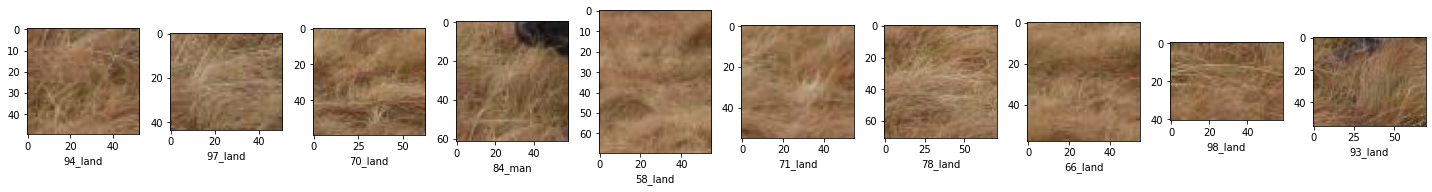

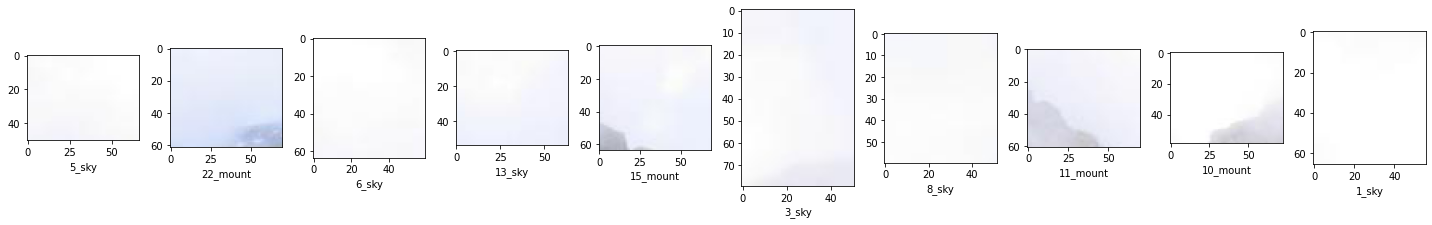

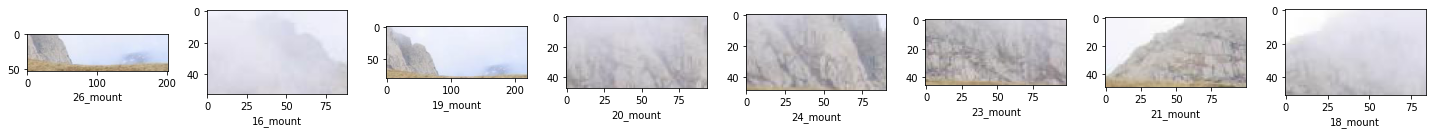

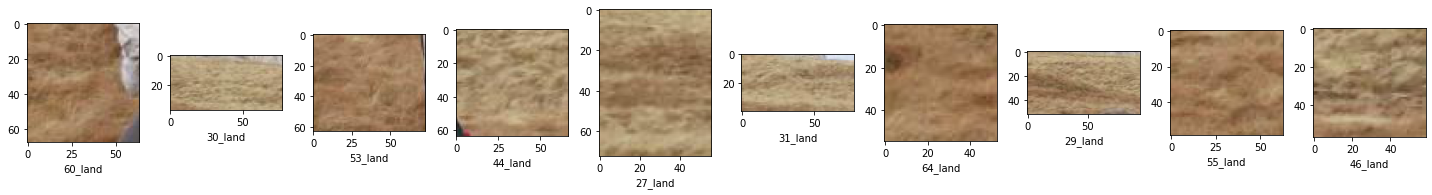

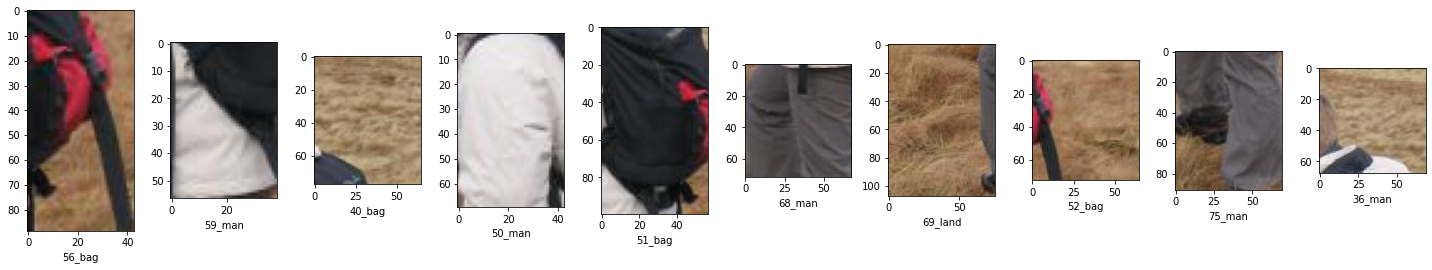

In [48]:
#plotting all images from each groups 
# pil_img = dImage(filename=pic_one)
# display(pil_img)


for g in groups.keys():
    imgs = groups[g][0:10]
    plt.subplots(1, len(imgs), figsize=(20, 10))
    for i, k in enumerate(imgs):
        im = Image.open(f'{path}/{k}')
        arr = np.array(im)
        plt.subplot(1, len(imgs), i + 1)
        plt.xlabel(k.replace('.png',''))
        plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()